# Easy Cash - Análise de Previsão de Inadimplência

INTRODUÇÃO

Na Sprint 02 será construido um modelo que possa predizer de acordo com os dados bancários de cada cliente, se essa pessoa pode ou não se tornar inadimplente

In [38]:
import pandas as pd
import numpy as np
from scipy.stats import iqr
import matplotlib.pyplot as plt
plt.rc('figure', figsize = (12,6))
%matplotlib inline

## Importando os dados para análise

In [2]:
dados = pd.read_csv('../data/processed/dados_unidos.csv')
dados.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,21.0,60000.0,Rent,2.0,Education,B,8000.0,11.26,0.0,0.13,N,3.0
1,40.0,70000.0,Mortgage,6.0,Education,A,18000.0,7.90,0.0,0.26,N,14.0
2,29.0,115000.0,Mortgage,3.0,Medical,C,22000.0,15.23,0.0,0.19,Y,7.0
3,26.0,84996.0,Rent,0.0,Medical,B,9000.0,11.26,0.0,0.11,N,2.0
4,23.0,54500.0,Rent,2.0,Debtconsolidation,A,8000.0,NaN,0.0,0.15,N,2.0


#### Renomeando Colunas

In [3]:
# Declarando dicionário para tradução das colunas (en -> pt)
dict_col_name = {
    'person_age': 'idade',
    'person_income': 'salario',
    'person_home_ownership': 'situacao_moradia',
    'person_emp_length': 'tempo_trabalho',
    'loan_intent': 'motivo_emprestimo',
    'loan_grade': 'pontuacao_emprestimo',
    'loan_amnt': 'valor_emprestimo',
    'loan_int_rate': 'taxa_juros',
    'loan_status': 'inadimplencia',
    'loan_percent_income': 'renda_percentual_emprestimo',
    'cb_person_default_on_file': 'devendo',
    'cb_person_cred_hist_length': 'tempo_de_credito'
}

In [4]:
# Renomeando Colunas (Axis = 1 -> Coluna)
#dados.rename(dict_col_name, axis= 1, inplace=True)
#dados.head()

***
# 1. Explore the credit data
***
Neste Dataset, a coluna `loan_status` mostra se o empréstimo está atualmente inadimplente = 1 e Não-Inadimplente= 0.

No dataset tem mais colunas nos dados e muitas podem ter um relacionamento com os valores em `loan_status`. Precisa explorar mais os dados e essas relações com uma análise mais aprofundada para entender o impacto dos dados nas inadimplências de empréstimos de crédito.

Verificar a estrutura dos dados, bem como ver um fotografia, nos ajuda a entender melhor o que está dentro do conjunto. Da mesma forma, as visualizações fornecem uma visão de alto nível dos dados, além de tendências e padrões importantes.


### Instruction 1/3:

In [5]:
# Check the structure of the data
print(dados.dtypes)

person_age                    float64
person_income                 float64
person_home_ownership          object
person_emp_length             float64
loan_intent                    object
loan_grade                     object
loan_amnt                     float64
loan_int_rate                 float64
loan_status                   float64
loan_percent_income           float64
cb_person_default_on_file      object
cb_person_cred_hist_length    float64
dtype: object


In [6]:
# Check the first five rows of the data
dados.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,21.0,60000.0,Rent,2.0,Education,B,8000.0,11.26,0.0,0.13,N,3.0
1,40.0,70000.0,Mortgage,6.0,Education,A,18000.0,7.90,0.0,0.26,N,14.0
2,29.0,115000.0,Mortgage,3.0,Medical,C,22000.0,15.23,0.0,0.19,Y,7.0
3,26.0,84996.0,Rent,0.0,Medical,B,9000.0,11.26,0.0,0.11,N,2.0
4,23.0,54500.0,Rent,2.0,Debtconsolidation,A,8000.0,NaN,0.0,0.15,N,2.0


### Instruction 2/3:

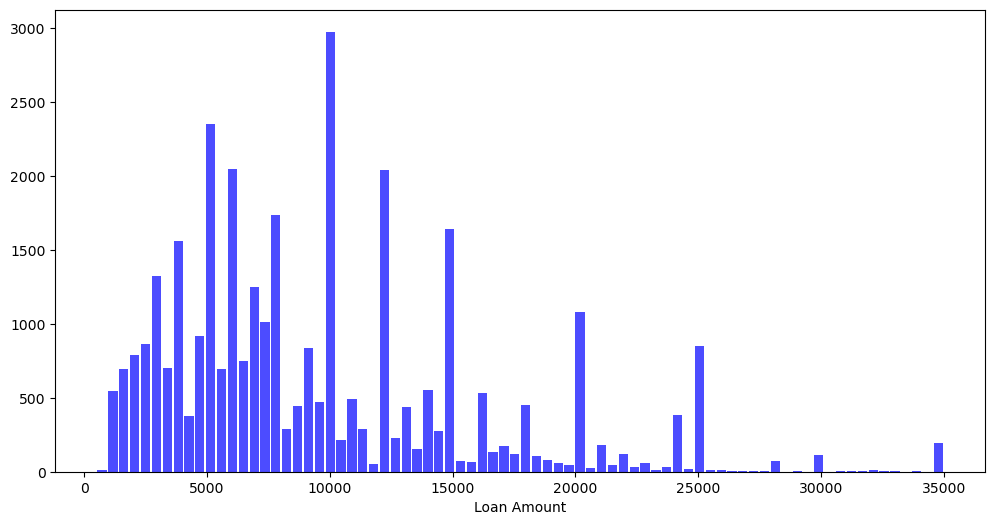

In [7]:
# Olhando a distribuição do valor de emprestimo com um histograma
n, bins, patches = plt.hist(x=dados['loan_amnt'], bins='auto', color='blue',alpha=0.7, rwidth=0.85)
plt.xlabel("Loan Amount")
plt.show()

### Instruction 3/3:
Create a scatter plot of a person's income and age. In this case, `person_income` is the independent variable and `person_age` is the dependent variable.

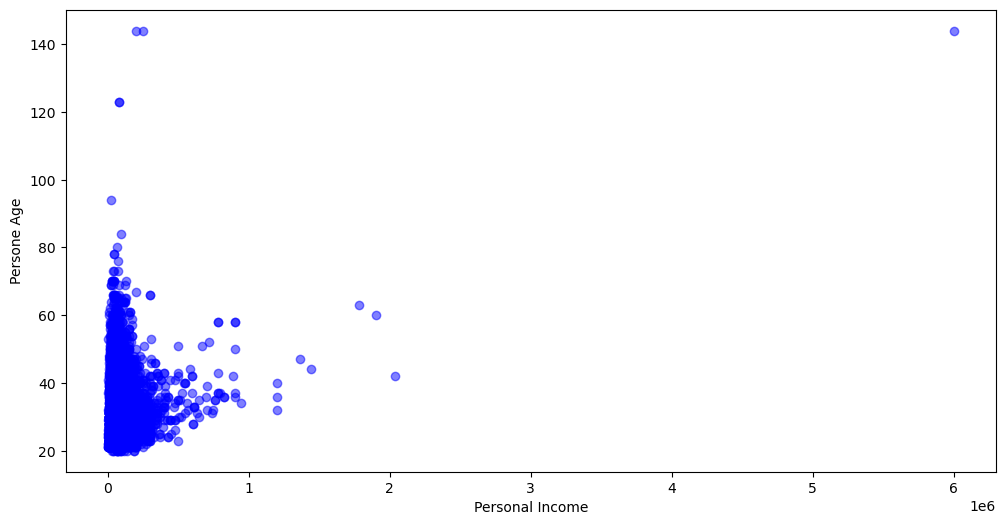

In [9]:
# Plot a scatter plot of income against age
plt.scatter(dados['person_income'], dados['person_age'],c='blue', alpha=0.5)
plt.xlabel('Personal Income')
plt.ylabel('Persone Age')
plt.show()

Great start! Starting with data exploration helps us keep from getting a.head() of ourselves! ***We can already see a positive correlation with age and income**, which could mean these older recipients are further along in their career and therefore earn higher salaries. There also appears to be ***an outlier in the data.***

***
# 2. Crosstab and pivot tables
***

Often, financial data is viewed as a pivot table in spreadsheets like Excel.

With cross tables, you get a high level view of selected columns and even aggregation like a count or average. For most credit risk models, especially for probability of default, columns like `person_emp_length` and `person_home_ownership` are common to begin investigating.

You will be able to see how the values are populated throughout the data, and visualize them. For now, you need ***to check how `loan_status` is affected by factors like home ownership status, loan grade, and loan percentage of income.**

In [16]:
pd.crosstab(index=dados['person_home_ownership'], columns= dados['loan_status'],
values=dados['loan_int_rate'], aggfunc='mean').round(2)

loan_status,0.0,1.0
person_home_ownership,,
Mortgage,10.06,13.42
Other,11.41,13.74
Own,10.75,12.32
Rent,10.75,12.97


### Instructions 1/4
Create a cross table of `loan_intent` and `loan_status`.

In [17]:
# Create a cross table of the loan intent and loan status
pd.crosstab(index= dados['loan_intent'], columns= dados['loan_status'], margins = True)

loan_status,0.0,1.0,All
loan_intent,,,
Debtconsolidation,3892,1532,5424
Education,5529,1173,6702
Homeimprovement,2789,968,3757
Medical,4643,1674,6317
Personal,4585,1144,5729
Venture,5045,887,5932
All,26483,7378,33861


In [18]:
# Create a cross table of the loan intent and loan status
pd.crosstab(index= dados['loan_intent'], columns= dados['loan_status'], margins = False)

loan_status,0.0,1.0
loan_intent,,
Debtconsolidation,3892,1532
Education,5529,1173
Homeimprovement,2789,968
Medical,4643,1674
Personal,4585,1144
Venture,5045,887


### Instructions 2/4
Create a cross table of home ownership grouped by `loan_status` and `loan_grade`.

In [19]:
# Create a cross table of home ownership, loan status, and grade
pd.crosstab(index= dados['person_home_ownership'],columns= [dados['loan_status'],dados['loan_grade']])

loan_status             0.0                               1.0              \
loan_grade                A     B     C    D    E   F  G    A     B     C   
person_home_ownership                                                       
Mortgage               5355  3825  1987  685  189  40  0  280   354   337   
Other                    23    30    11    9    2   0  0    3     6     6   
Own                     885   791   477  274   26   7  0   74    40    34   
Rent                   3718  4349  2795  599  153  32  1  792  1366  1011   

loan_status                                
loan_grade                D    E    F   G  
person_home_ownership                      
Mortgage                563  162   61  31  
Other                    11    6    2   0  
Own                      19   31    8   5  
Rent                   1579  425  100  27

### Instructions 3/4
Create a cross table of home ownership, loan status, and average `loan_percent_income`

In [20]:
# Create a cross table of home ownership, loan status, and average percent income
pd.crosstab(index= dados['person_home_ownership'], columns= dados['loan_status'],
              values=dados['loan_percent_income'], aggfunc='mean')

loan_status,0.0,1.0
person_home_ownership,,
Mortgage,0.146539,0.186730
Other,0.144133,0.306471
Own,0.179491,0.296364
Rent,0.144940,0.264224


### Instructions 3/4
Create a boxplot of the `loan_percent_income` of the person's income grouped by `loan_status`

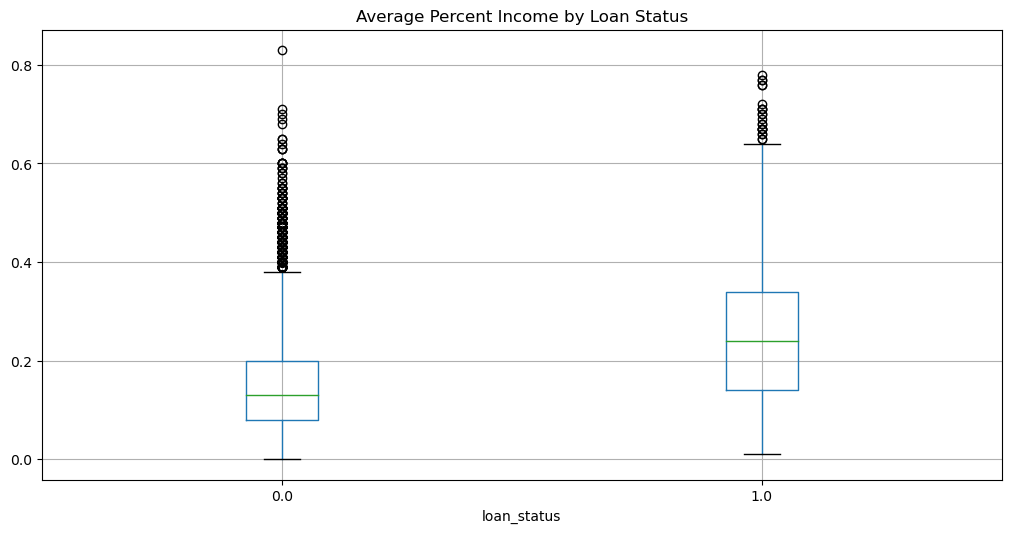

In [21]:
dados.boxplot(column = ['loan_percent_income'], by = 'loan_status')
plt.title('Average Percent Income by Loan Status')
plt.suptitle('')
plt.show()

Bom trabalho! Parece que a porcentagem média de renda para inadimplentes é maior. ***Isso pode indicar que esses destinatários têm uma relação dívida/renda que já é muito alta.***

***
# 3. Finding outliers with cross tables
***

Now you need **to find and remove outliers** you suspect might be in the data. For this exercise, you can use ***cross tables*** and ***aggregate functions***.

Have a look at the `person_emp_length` column. You've used the aggfunc = 'mean' argument to see the average of a numeric column before, but to detect outliers you can use other functions like min and max.

It may not be possible for a person to have an employment length of less than 0 or greater than 60. You can use cross tables to check the data and see if there are any instances of this!

### Instructions 1/4
Print the cross table of `loan_status` and `person_home_ownership` with the max `person_emp_length`.

In [22]:
# Create the cross table for loan status, home ownership, and the max employment length
pd.crosstab(index = dados['loan_status'], columns= dados['person_home_ownership'], 
            values= dados['person_emp_length'], aggfunc= 'max')

person_home_ownership,Mortgage,Other,Own,Rent
loan_status,,,,
0.0,123.0,24.0,31.0,41.0
1.0,34.0,11.0,17.0,123.0


### Instructions 2/4
Create and array of indices for records with an employment length greater than 60. Store it as indices.

In [28]:
# Create an array of indices where employment length is greater than 60
indices= dados[dados['person_emp_length'] > 60].index
indices

Int64Index([8200, 21177], dtype='int64')

### Instructions 3/4
Drop the records from the data using the array indices and create a new dataframe called `cr_loan_new`.

In [27]:
# Drop the records from the data based on the indices and create a new dataframe
cr_loan_new= dados.drop(indices)

### Instructions 4/4
Create the cross table from earlier and include minimum employment length

In [30]:
pd.crosstab(cr_loan_new['loan_status'],cr_loan_new['person_home_ownership'],
            values=cr_loan_new['person_emp_length'], aggfunc=['min','max'])

min                      max                  
person_home_ownership Mortgage Other  Own Rent Mortgage Other   Own  Rent
loan_status                                                              
0.0                        0.0   0.0  0.0  0.0     38.0  24.0  31.0  41.0
1.0                        0.0   0.0  0.0  0.0     34.0  11.0  17.0  27.0

Geralmente com dados de crédito, colunas-chave como `person_emp_length` são de alta qualidade, mas sempre há espaço para erros. Com isso em mente, construímos nossa intuição para detectar outliers!

***
# 4. Visualizing credit outliers
***

Você descobriu outliers em `person_emp_length`, onde valores maiores que 60 estavam muito acima do normal. 
`person_age` é outra coluna na qual uma pessoa pode usar uma abordagem de bom senso para dizer que é muito improvável que uma pessoa solicitando um empréstimo tenha mais de 100 anos. 

Visualizar os dados aqui pode ser outra maneira fácil de detectar outliers. Você pode usar outras colunas numéricas como `loan_amnt` e `loan_int_rate` para criar gráficos com `person_age` para pesquisar outliers.

### Instructions 1/2
Create a scatter plot of `person_age` on the x-axis and `loan_amnt` on the y-axis.

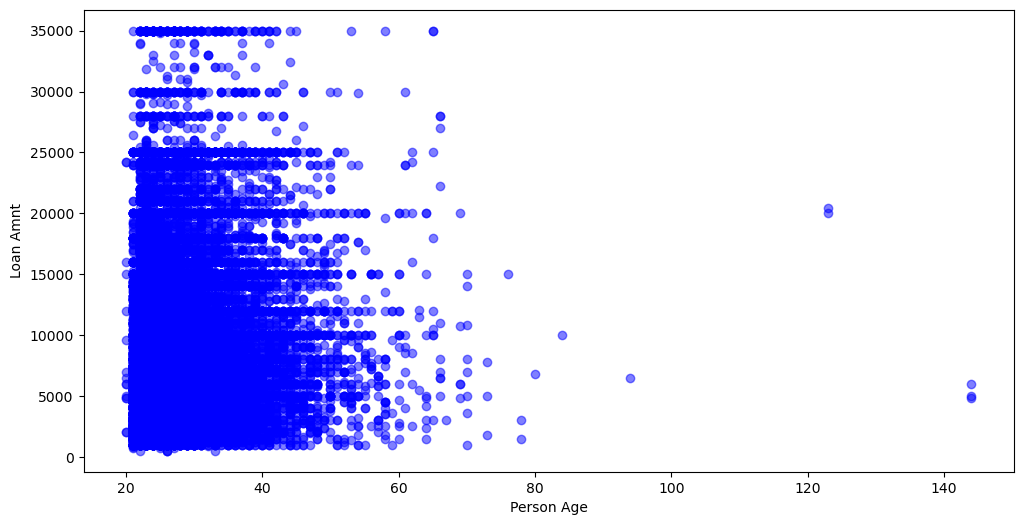

In [33]:
plt.scatter(x= cr_loan_new['person_age'], y= cr_loan_new['loan_amnt'], c='blue', alpha= 0.5)
plt.xlabel('Person Age')
plt.ylabel('Loan Amnt')
plt.show()

### Instructions 2/2
Use the .drop() method from Pandas to remove the outliers and create `cr_loan_new`.

Create a scatter plot of age on the x-axis and loan interest rate on the y-axis with a label for `loan_status`.

In [45]:
# Use Pandas to drop the record from the data frame and create a new one
cr_loan_new.drop(cr_loan_new[cr_loan_new['person_age'] > 100].index, inplace= True)

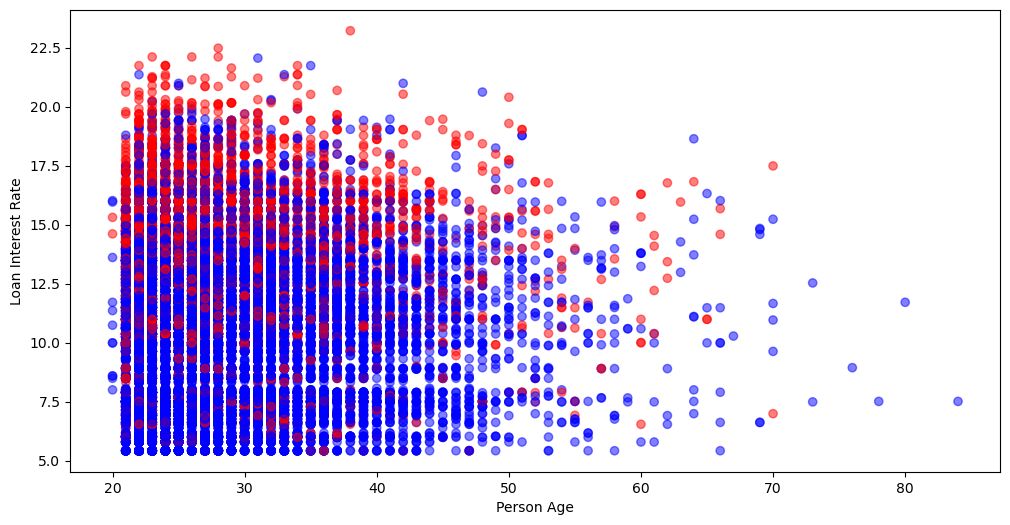

In [46]:
import matplotlib.colors 
# Create a scatter plot of age and interest rate
colors = ["blue","red"]
plt.scatter(cr_loan_new2['person_age'], 
            cr_loan_new2['loan_int_rate'],
            c = cr_loan_new2['loan_status'],
            cmap = matplotlib.colors.ListedColormap(colors),
            alpha=0.5)
plt.xlabel("Person Age")
plt.ylabel("Loan Interest Rate")
plt.show()

Observe que, no último gráfico, temos `loan_status` como um rótulo para as cores. Isso mostra uma cor diferente, dependendo da classe. Nesse caso, é inadimplência e não inadimplência, e parece que ***há mais inadimplência com altas taxas de juros.***

***
# 5. Replacing missing credit data
***
Agora, você deve verificar se há dados ausentes. Se você encontrar dados ausentes em `loan_status`, não poderá usar os dados para prever a probabilidade de inadimplência porque não saberá se o empréstimo foi inadimplente ou não. 

A falta de dados dentro de `person_emp_length` não seria tão prejudicial, mas ainda causaria erros de treinamento.

Portanto, verifique se há dados ausentes na coluna `person_emp_length` e substitua os valores ausentes pela mediana


**Nota:** Verificar a apresentação sobre dados ausentes e técnicas

### Instructions 1/4
Print an array of column names that contain missing data using .isnull().

In [47]:
# Print a null value column array
print(cr_loan_new.columns[cr_loan_new.isnull().any()])

Index(['person_age', 'person_income', 'person_home_ownership',
       'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt',
       'loan_int_rate', 'loan_status', 'loan_percent_income',
       'cb_person_default_on_file', 'cb_person_cred_hist_length'],
      dtype='object')


### Instructions 2/4
Print the top five rows of the data set that has missing data for person_emp_length.

In [50]:
cr_loan_new[cr_loan_new['person_emp_length'].isnull()].head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
27,34.0,120000.0,Rent,NaN,Debtconsolidation,A,2000.0,NaN,NaN,0.04,N,3.0
197,21.0,12540.0,Rent,NaN,Homeimprovement,A,2500.0,7.88,1.0,0.20,N,2.0
215,37.0,35000.0,Rent,NaN,Debtconsolidation,D,8000.0,5.42,NaN,0.36,N,4.0
228,34.0,29152.0,Rent,NaN,Venture,B,5000.0,10.36,0.0,0.17,N,7.0
345,30.0,49000.0,Own,NaN,Medical,A,12000.0,14.27,NaN,0.16,Y,2.0


### Instructions 3/4
Replace the missing data with the median of all the employment length using .fillna()

In [51]:
# Impute the null values with the median value for all employment lengths
cr_loan_new['person_emp_length'].fillna((cr_loan_new['person_emp_length'].median()), inplace=True)

### Instructions 4/4
Create a histogram of the `person_emp_length` column to check the distribution.

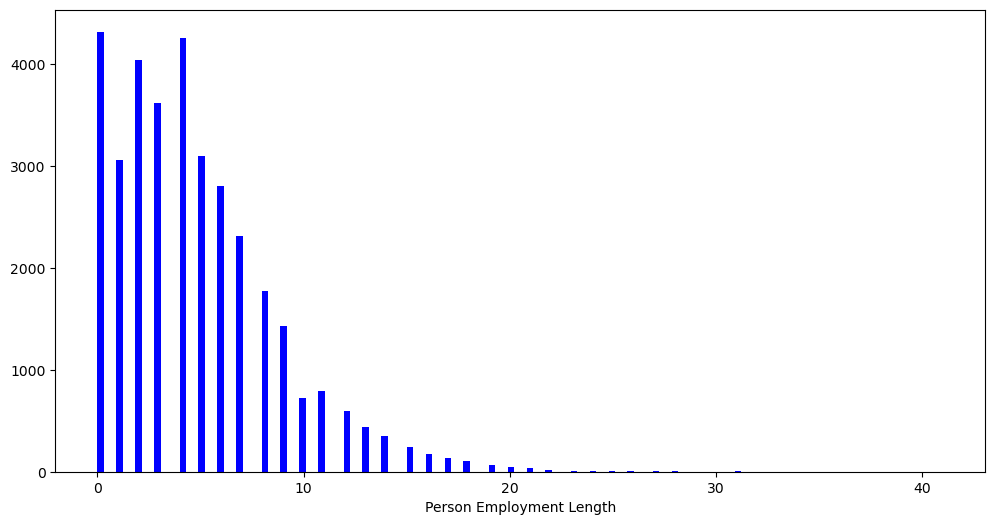

In [52]:
# Create a histogram of employment length
n, bins, patches = plt.hist(cr_loan_new['person_emp_length'], bins='auto', color='blue')
plt.xlabel("Person Employment Length")
plt.show()

Correto! Você pode usar várias funções diferentes como mean() e median() para substituir os dados ausentes. O objetivo aqui é manter o máximo possível de nossos dados! Também é importante verificar a distribuição desse recurso para ver se ele mudou.

***
# 6. Removing missing data
***
Você substituiu os dados ausentes em `person_emp_length`, mas no exercício anterior você viu que `loan_int_rate` também possui dados ausentes.

Semelhante a ter dados ausentes em `loan_status`, ter dados ausentes em `loan_int_rate` dificultará as previsões.

Como as taxas de juros são definidas pela sua empresa, é muito estranho não ter dados nesta coluna. É possível que os problemas de ingestão de dados tenham criado erros, mas você não pode ter certeza. Por enquanto, é melhor usar .drop() para esses registros antes de prosseguir.

### Instructions

In [53]:
# Print the number of nulls
print(cr_loan_new['loan_int_rate'].isnull().sum())

3629


In [54]:
# Store the array on indices
indices = cr_loan_new[cr_loan_new['loan_int_rate'].isnull()].index

In [57]:
# Save the new data without missing data
cr_loan_new.drop(indices, inplace= True)

Legal! Agora que os dados ausentes e discrepantes foram processados, os dados estão prontos para modelagem! Na maioria das vezes, os dados financeiros são bastante organizados, mas é sempre bom praticar a preparação de dados para o trabalho analítico

### Missing data intuition
Ao lidar com dados ausentes, você tem três opções: 
- manter(keep), 
- substituir(replace) 
- remover(remove)

Você está olhando para colunas numéricas, mas e quanto a uma coluna não-numérica? Como você lidaria com os dados ausentes na coluna `person_home_ownership` que possui valores de string?

In [58]:
# Count the number of records for each unique value
cr_loan_new['person_home_ownership'].value_counts()

Rent        15478
Mortgage    12585
Own          2449
Other          95
Name: person_home_ownership, dtype: int64

Você tem razão! Já temos uma classe completa dentro de person_home_ownership que armazena todos os outros tipos de propriedade residencial como Outro. Com isso, eliminamos dados perdidos sem afetar os dados como um todo